In [72]:
import numpy as np
import time
import math
import modules as md
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as mpatches




#------------------------------------------------------------------------------------------
#Units and conversioHzns:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

In [73]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

In [74]:
from timeit import default_timer as timer

# Newton

In [75]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Jev = np.zeros((len(r),3))
    Jer = np.zeros((len(r),3))
    Jet = np.zeros((len(r),3))#Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                #Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
                Jev[i] += - m[j]*((vrel)/rn**3.0) 
                Jer[i] += - 3.*(rvd*rrel/(rn**5.0))
                Jet[i] += Jev[i] + Jer[i] 
    return Jet, Jer;

## Newtonian only integrator 

In [76]:
def HermiteUpdateNtdt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    #aD = accdiss(r, m, ns)
    #aPN, aPNradial = accPN(r, v, m)
    a = aN #+ aPN #+ aT # current acceleration
    aradial = aN #+ aPNradial
    
    aNdot, aNdotradial = Jerk(r,v,m)
    #aDdot = Jerkdiss(r, v, m, ns)
    #aPNdot, aPNdotradial = JerkPN(r, v, a, m)
    adot = aNdot #+ aPNdot #+ aDdot # current jerks
    adotradial = aNdotradial #+ aPNdotradial
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    #aPNp, aPNpradial = accPN(rp, vp, m)
    #aDp = accdiss(rp, m, ns)
    ap = aNp #+ aPNp #+ aDp        # predicted acceleration
    apradial = aNp #+ aPNpradial
    
    aNdotp, aNdotpradial = Jerk(rp, vp, m)
    #aPNdotp, aPNdotpradial = JerkPN(rp, vp, ap, m)
    #aDdotp = Jerkdiss(rp, vp, m, ns)
    adotp = aNdotp #+ aPNdotp #+  aDdotp  # predicted jerks 
    adotpradial = aNdotpradial #+ aPNdotpradial 

    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + (adotp+adot)*dt/2
    acradial = aradial + (adotpradial+adotradial)*dt/2

 
    return rc,vc,ac,acradial,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thNtdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    a_radial = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.eta, sec.eta])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],a_radial[:,:,i], dtp[i]) = HermiteUpdateNtdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < (3.)*(pri.radisch): #This is when running an equal mass bbh
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    a_radial = a_radial[:,:,:i]
    #adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, a_res, a_radial, time #, aN_res, adotN_res, a_res, adot_res, 


# PN 

In [77]:
#PN Acceleration
def accPN(r,v,m): #r position, m mass, s spin, m mass of secondary
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    arad = np.zeros((len(r),3)) #Create acceleration vector

    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle           
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = 1.*rrel/rn
                #rvd = ((rrel)*(vrel)).sum()
                ruvd = ((runi)*(vrel)).sum()
                v2d = (vrel**2).sum()
                a1[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*((2*m[i]/rn - 8*m[j]/rn - v2d)*vrel)
                arad[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*(runi*(ruvd)*(52.0*m[j]/(3*rn) - 6*m[i]/rn + 3.0*v2d))
                a[i] += a1[i] + arad[i] #a1[i] +  
    return a, arad#, a1, a2 # return acceleration


#PN Jerk v2

def JerkPN(r,v,a,m): #position, velocity, mass
    JePNLO3 = np.zeros((len(r),3))
    JePNLO3v2 = np.zeros((len(r),3))
    JePNLO4 = np.zeros((len(r),3))
    JePNLO5 = np.zeros((len(r),3))#Define the Jerk
    JePNLO3radial = np.zeros((len(r),3))
    JePNLO4radial = np.zeros((len(r),3))
    JePNLO5radial = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                arel = a[i]-a[j]
                rn = ((rrel**2).sum())**(1./2) #norm                                                    
                vn = ((vrel**2).sum())**(1./2) 
                runi = 1.*rrel/rn
                ruvd = (runi*vrel).sum()   
                ruad = (runi*arel).sum()                                                  
                vad = (vrel*arel).sum()
                #JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*arel + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel) + 2*( vad*ruvd + (vn**2)*ruad)*runi))                
                JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*arel + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel)))                
                
                #JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*arel+ 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*arel)
                
                #JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + ruvd*vrel - 6*((ruvd**2)*runi)))
                JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*(ruvd*vrel))
                
                JePNLO3radial[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(3*(2*( vad*ruvd + (vn**2)*ruad)*runi))
                JePNLO4radial[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(+ 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                JePNLO5radial[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(((52./3)*m[j]-6*m[i])*((vn**2)*runi- 6*((ruvd**2)*runi)))
                JePNLOradial = JePNLO3radial + JePNLO4radial + JePNLO5radial
                JePNLOt = JePNLO3 + JePNLO3radial + JePNLO4 + JePNLO4radial + JePNLO5 + JePNLO5radial
    return JePNLOt, JePNLOradial 


## PN integrator 

In [78]:
def HermiteUpdatePNtdt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    #aD = accdiss(r, m, ns)
    aPN, aPNradial = accPN(r, v, m)
    a = aN + aPN #+ aT # current acceleration
    aradial = aN + aPNradial
    
    aNdot, aNdotradial = Jerk(r,v,m)
    #aDdot = Jerkdiss(r, v, m, ns)
    aPNdot, aPNdotradial = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot #+ aDdot # current jerks
    adotradial = aNdotradial + aPNdotradial
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp, aPNpradial = accPN(rp, vp, m)
    #aDp = accdiss(rp, m, ns)
    ap = aNp + aPNp #+ aDp        # predicted acceleration
    apradial = aNp + aPNpradial
    
    aNdotp, aNdotpradial = Jerk(rp, vp, m)
    aPNdotp, aPNdotpradial = JerkPN(rp, vp, ap, m)
    #aDdotp = Jerkdiss(rp, vp, m, ns)
    adotp = aNdotp + aPNdotp #+  aDdotp  # predicted jerks 
    adotpradial = aNdotpradial + aPNdotpradial 

    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + (adotp+adot)*dt/2
    acradial = aradial + (adotpradial+adotradial)*dt/2

 
    return rc,vc,ac,acradial,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNtdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    a_radial = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.eta, sec.eta])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],a_radial[:,:,i], dtp[i]) = HermiteUpdatePNtdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < (3.)*(pri.radisch): #This is when running an equal mass bbh
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    a_radial = a_radial[:,:,:i]
    #adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, a_res, a_radial, time #, aN_res, adotN_res, a_res, adot_res, 


#  Simulations

# Equal mass case 

# Start simulation with frequency of 10 Hz.  

Make a simulation starting at $d_i = 30 r_s$ , which corresponds to ~ 10 Hz

Masses of the BHs 20 solar masses

In [79]:
#Define black holes
bh = md.Particle("BH",20,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

#Define binary
#bhbh = md.Binary(bh, bh, bh.radisch*10, 0) ##primary, secondary, orbital distance (Rsun), eccentricity 

#Test dissipative effects
bhbh = md.Binary(bh, bh, bh.radisch*30, 0)

In [80]:
#Have implemented it, need to check it
timetomerge =  (5./256)*(bhbh.orbd**4)*(c_CU**5)*(1./(bh.mass*bh.mass*(bh.mass+bh.mass)))

print(timetomerge/bhbh.periodct)

#accu = 0.001 #0.0001 Set accuracy parameter
#tl = 100*bhbh.periodct #Time of the simulation in [code units]
tl = 20*bhbh.periodct
timelimit = tl #
#dt = 0.01 #Guess a timestep
#test diss
dt= 100#0.01#0.1#use 0.01 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

61.293341580385814


# Modified this to run for PN only and generate initial conditions 

In [81]:
start = timer()
ric,vic,aic,aicradial,timeic = Hermite4thPNtdt(bh,bh, bhbh, Nsteps, dt)
end= timer()

In [82]:
print((end-start)/60, 'minutes')
print(end - start)

0.20429787543253042 minutes
12.257872525951825


No handles with labels found to put in legend.


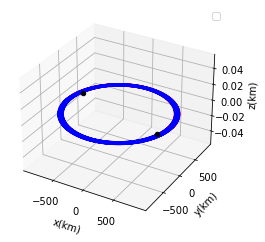

In [83]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(ric[0][0], ric[0][1], ric[0][2], 'r', linewidth=1)# Plot the BH orbit
ax.plot(ric[1][0], ric[1][1], ric[1][2], 'b', linewidth=1)# Plot the star orbit
ax.scatter3D(ric[0][0][-1], ric[0][1][-1], ric[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(ric[1][0][-1], ric[1][1][-1], ric[1][2][-1], 'o', c='black') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [84]:
rrelic = ric[0] - ric[1]
vrelic = vic[0] - vic[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dic = np.zeros(len(rrelic .T)) 

for i in range(len(rrelic.T)):
    dic[i] = np.linalg.norm(rrelic.T[i])
    
#Obtain the relative velocity
vnrelic = np.zeros(len(vrelic.T))

for i in range(len(rrelic.T)):
    vnrelic[i] = np.linalg.norm(vrelic.T[i])
    
vnrelickm = vnrelic/kmsec_U*1000/c_SI
timeicsec = timeic*time_U

print(dic[-1]/bh.radisch)

#arelic = aic[0].T-aic[1].T aicradial
arelicradial = aicradial[0].T-aicradial[1].T
wsic = np.zeros([len(dic)])
wsicG = np.zeros([len(dic)])

for i in range(len(dic)): 
    wsic[i] = np.sqrt(np.linalg.norm(arelicradial[i])/(dic[i]))
    
    gammaic = 1./(1 - (vnrelic[i]/c_CU)**2)**(1./2)#1.
    wsicG[i] = np.sqrt(np.linalg.norm(arelicradial[i])/(gammaic*dic[i]))


27.18451228543944


In [85]:
f_gwic = (wsic/np.pi)/time_U
print(f_gwic)

[ 0.          9.83581144  9.83581145 ... 11.40214764 11.40237526
 11.4026032 ]


# Only N 

In [86]:
start = timer()
rN,vN,aN,aNradial,timeN, = Hermite4thNtdt(bh,bh, bhbh, Nsteps, dt)
end = timer()

In [87]:
print((end - start)/60)

0.0629934670345392


No handles with labels found to put in legend.


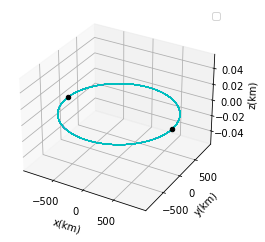

In [88]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rN[0][0], rN[0][1], rN[0][2], 'm', linewidth=1)# Plot the BH orbit
ax.plot(rN[1][0], rN[1][1], rN[1][2], 'c', linewidth=1)# Plot the star orbit
ax.scatter3D(rN[0][0][-1], rN[0][1][-1], rN[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rN[1][0][-1], rN[1][1][-1], rN[1][2][-1], '0', c='black') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')

#plt.savefig('Ncolns.eps', bbox_inches='tight')#, dpi=200
#plt.savefig('Norbitaldecay.Ng', format='Ng', dpi=200)#, dpi=200
#plt.savefig('Norbitaldecay.eps', bbox_inches='tight', format='eps')#,

plt.show()

In [89]:
rrelN = rN[0] - rN[1]
vrelN = vN[0] - vN[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dN = np.zeros(len(rrelN .T)) 

for i in range(len(rrelN.T)):
    dN[i] = np.linalg.norm(rrelN.T[i])
    
#Obtain the relative velocity
vnrelN = np.zeros(len(vrelN.T))

for i in range(len(rrelN.T)):
    vnrelN[i] = np.linalg.norm(vrelN.T[i])
    
vnrelNkm = vnrelN/kmsec_U*1000/c_SI
timeNsec = timeN*time_U

#arelN = aN[0].T-aN[1].T

arelNradial = aNradial[0].T-aNradial[1].T
wsN = np.zeros([len(dN)])
wsNG = np.zeros([len(dN)])

for i in range(len(dN)):
    wsN[i] = np.sqrt(np.linalg.norm(arelNradial[i])/(dN[i]))
    
    gammaN = 1./(1 - (vnrelN[i]/c_CU)**2)**(1./2)   #1.
    wsNG[i] = np.sqrt(np.linalg.norm(arelNradial[i])/(gammaN*dN[i]))
    
